In [1]:
%pylab inline
import sys
sys.path.append('../build_gcc/')
import versor as vsr
from liblds_calibration import (LaserDistanceSensorCalibrator, transform_tangent_vector)
from game import solver_options
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


versor/cga.py:4: RuntimeWarning: to-Python converter for vsr::Multivector<vsr::algebra<vsr::metric<4, 1, true>, double>, vsr::Basis<(short)1, (short)2, (short)4, (short)8, (short)16> > already registered; second conversion method ignored.
  from libversor import (Biv, Bst, Cir, Con, Dil, Dll, Dlp, Dls, Drb, Drt, Drv,
versor/cga.py:4: RuntimeWarning: to-Python converter for vsr::Multivector<vsr::algebra<vsr::metric<4, 1, true>, double>, vsr::Basis<(short)9, (short)10, (short)12> > already registered; second conversion method ignored.
  from libversor import (Biv, Bst, Cir, Con, Dil, Dll, Dlp, Dls, Drb, Drt, Drv,


# Laser Distance Sensor Calibration

$$ R = \frac{1 + \mathrm{b}\mathrm{a}}{\sqrt{2(1 + \mathrm{b} \rfloor \mathrm{a})}} $$

In [2]:
rotor_from_vectors = lambda a, b: (b * a + 1) / np.sqrt(2*(1+(b <= a)[0]))

## Create measurement poses

In [3]:
# laser direction in end-effector
l0 = vsr.Vec(1,0,0).spin( vsr.Rot.from_bivector(vsr.Biv(1,0,0) * pi/ 3))
p0 = vsr.Vec(0.1,0.2,0.3)
R0 = rotor_from_vectors(vsr.Vec(1,0,0), l0)
T0 = vsr.Trs.from_vector(p0)
M_laser_in_ee = T0 * R0
print(l0)
print(p0)
print(M_laser_in_ee)

[ 0.5    0.866  0.   ]
[ 0.1  0.2  0.3]
[ 0.866  -0.5     0.      0.     -0.0933 -0.0616 -0.1299  0.075 ]


In [4]:
# Laser sensor
lower = 0.065
upper = 0.095
# lower = 0.01
# upper = lower + 0.2
generate_measurement_distance = lambda : (upper - lower) * np.random.rand() + lower

In [32]:
def create_point_on_sphere():
    r = generate_measurement_distance()
    theta = np.random.rand() * (np.pi / 2.0) * 0.9 + (np.pi / 2.0) * 0.1
    phi = np.random.rand() * np.pi * 2.0 
    return vsr.Vec(r*np.sin(theta)*np.cos(phi),
                   r*np.sin(theta)*np.sin(phi),
                   r*np.cos(theta)), r

Create point on upper hemisphere on measurement sphere:

$$ 
x = r \sin (\theta) \cos(\varphi),\
y = r \sin (\theta) \cos(\varphi),\ 
z = r \cos(\varphi) 
$$

In [33]:
def generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane):
    # Model laser as tangent vector in the e_1-direction at the origin
    lds_dir = vsr.Vec(1,0,0)
    lds_tnv = vsr.no ^ lds_dir
    # Model the measurement plane as plane through the orgin with
    # normal vector \hat{n} = e_3
    dlp = dlp = vsr.Dlp(0,0,1,0)
    # Create point on upper hemisphere of measurement sphere with 
    # radius equals the measurement distance
    p, radius = create_point_on_sphere()
    # Compute motor that aligns lds_dir with measurement vector from 
    # from point on circle to the origin
    R = rotor_from_vectors(lds_dir, -p.unit())
    T = vsr.Trs.from_vector(p)
    M_on_sphere = T * R * vsr.Rot.from_bivector(vsr.Vec(1,0,0).duale() * 
                                                np.random.rand() * 2 * pi)
    # Transform the everything the measurement plane
    x_in_plane = np.random.rand()
    y_in_plane = np.random.rand()
    T_in_plane = vsr.Trs.from_vector(vsr.Vec(x_in_plane, y_in_plane, 0.0)) * vsr.Rot(1.0,0.0,0.0,0.0)
    # Transform the plane
    dlp_meas = dlp.spin(M_plane)
    M2 = M_plane * T_in_plane * M_on_sphere * M_laser_in_ee.rev()   
    return M2, dlp_meas, radius

In [34]:
# M, dlp, r = generate_measurement_pose_and_plane_and_distance(M_laser_in_ee)
# t2 = transform_tangent_vector(M * M_laser_in_ee,  (vsr.no ^ vsr.Vec(1,0,0)))
# s = (dlp <= t2) / (vsr.ni <= (dlp <= t2))[0]
# np.allclose(r, np.sqrt((s <= s)[0]))

In [35]:
lin = (p0.null() ^ (l0 ^ vsr.ni))
print (p0.null() ^ vsr.ni)

[ 0.1  0.2  0.3  1. ]


In [36]:
M_plane = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,0,1), 0, vsr.Vec(1,1,0))
measurements1 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane) for i in range(10)]
M_plane2 = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,1,0), np.pi/3, vsr.Vec(1,1,0.0))
measurements2 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane2) for i in range(10)]
M_plane3 = vsr.Mot.from_dir_ang_trs(vsr.Vec(1,0,0), np.pi/2, vsr.Vec(1,1,0.0))
measurements3 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane3) for i in range(10)]
measurements = measurements1 + measurements2 + measurements3
measurements_copy = np.array(measurements).copy()

In [37]:
print M_plane

[ 1.  -0.   0.  -0.  -0.5 -0.5  0.   0. ]


In [38]:
options = solver_options()
options['function_tolerance'] = 1e-12
options['parameter_tolerance'] = 1e-12
options['max_num_iterations'] = 100
options['num_linear_solver_threads'] = 100
options['num_threads'] = 100
# options['trust_region_strategy_type'] = 'DOGLEG'
# options['linear_solver_type'] = 'SPARSE_NORMAL_CHOLESKY'

[ 0.9529 -0.3032  0.      0.     -0.0905 -0.0866 -0.1525  0.0485]
[ 0.866  -0.5     0.      0.     -0.0933 -0.0616 -0.1299  0.075 ]
[ 0.9224 -0.3405 -0.1805  0.0277 -0.1123 -0.0781 -0.1212  0.0261]
Ceres Solver Report: Iterations: 40, Initial cost: 8.807841e-04, Final cost: 5.938681e-05, Termination: CONVERGENCE


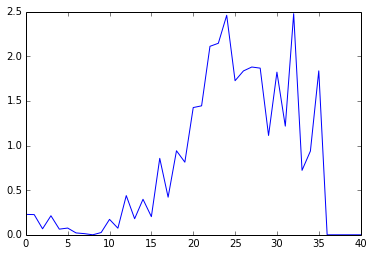

In [50]:
M_plane = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,0,1), 0, vsr.Vec(1,1,0))
measurements1 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane) for i in range(5)]
M_plane2 = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,1,0), -np.pi/3, vsr.Vec(1,1,0.0))
measurements2 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane2) for i in range(0)]
M_plane3 = vsr.Mot.from_dir_ang_trs(vsr.Vec(1,0,0), -np.pi/6, vsr.Vec(1,1,0.0))
measurements3 = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee, M_plane3) for i in range(0)]
measurements = measurements1 + measurements2 + measurements3
measurements_copy = np.array(measurements).copy()

# laser direction in end-effector
l = vsr.Vec(1,0,0).unit().spin(vsr.Rot.from_bivector(vsr.Biv(1,0,0).unit() * np.pi/5.1))
p = vsr.Vec(0.1 + 0.02, 0.2 + 0.02, 0.3 + 0.02)
R = rotor_from_vectors(vsr.Vec(1,0,0), l)
T = vsr.Trs.from_vector(p)
M_initial = T * R

print(M_initial)

print(M_laser_in_ee)

lds_calibrator = LaserDistanceSensorCalibrator(M_initial, options)

for measurement in measurements:
    M, dlp_meas, r = measurement
    r += np.random.randn() * 0.01
    lds_calibrator.add_tangent_vector_residual_block(M, dlp_meas, r)

# lds_calibrator.set_parameterization('POLAR_DECOMPOSITION')

lds_calibrator.set_parameterization('BIVECTOR_GENERATOR')

motor, summary = lds_calibrator.solve()

print(motor)
print(summary['brief_report'])

iterations = summary['iterations']
plot([it['gradient_max_norm'] for it in iterations])

In [51]:
print(summary['full_report'])


Solver Summary (v 1.10.0-eigen-(3.2.0)-lapack-suitesparse-(4.2.1)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                             5                        5
Residual                                    5                        5

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                   100                      100
Linear solver threads                     100                      100

Cost:
Initial                          8.807841e-04
Final               

In [52]:
errors = []
for measurement in measurements:
    dlp = measurement[1]
    t = transform_tangent_vector(measurement[0] * motor,  (vsr.no ^ vsr.Vec(1,0,0)))
    s = (dlp <= t) / (vsr.ni <= (dlp <= t))[0]
    r_est = np.sqrt((s <= s)[0])
    errors.append(np.abs(r_est - measurement[2]))
print(np.sum(errors) / 1000)

4.77414214337e-05


In [53]:
print(vsr.Vec(0,0,0).null().spin(motor).to_array())
np.allclose(vsr.Vec(0,0,0).null().spin(motor).to_array(), 
            vsr.Vec(0,0,0).null().spin(M_laser_in_ee).to_array())

[ 0.1087  0.2178  0.2776  1.      0.0682]


False

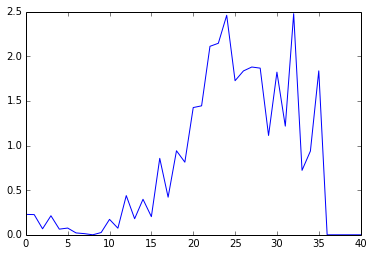

In [54]:
iterations = summary['iterations']
plot([it['gradient_max_norm'] for it in iterations])

## Point direction

In [55]:
p_initial = vsr.Vec(0,0,0).null().spin(M_initial)
p_initial = vsr.Vec(*p_initial.to_array()[:3])
l_initial = (vsr.Vec(1,0,0) ^ vsr.ni).spin(M_initial)
l_initial = vsr.Vec(*l_initial.to_array()[:3])
p_initial2 = vsr.Vec(*p_initial.to_array().copy()[:3])
l_initial2 = vsr.Vec(*l_initial.to_array().copy()[:3])
print(p0)
print(p_initial)
print(l0)
print(l_initial)
lds_calibrator = LaserDistanceSensorCalibrator(p_initial, l_initial, options)

[ 0.1  0.2  0.3]
[ 0.12  0.22  0.32]
[ 0.5    0.866  0.   ]
[ 0.8162  0.5778  0.    ]


In [62]:
for measurement in measurements:
    M, dlp_meas, r = measurement
    r += np.random.randn() * 0.0001
    lds_calibrator.add_point_direction_residual_block(M, dlp_meas, r)

In [ ]:
lds_calibrator.set_direction_parameterization('NORMALIZE')
p, l, summary2 = lds_calibrator.solve_point_direction()
print(summary2['brief_report'])
print(p)
print(l.unit())

In [ ]:
print(summary2['full_report'])

In [1]:
iterations = summary2['iterations']
plot([it['gradient_max_norm'] for it in iterations])

NameError: name 'summary2' is not defined

In [60]:
print p

[ 0.0822  0.2162  0.3136]


In [ ]:
p = p0.null().spin(measurements[0][0])
p = vsr.Vec(p[0], p[1], p[2])
l = (l0 ^ vsr.ni).spin(measurements[0][0])
l = vsr.Vec(l[0], l[1], l[2])
n = vsr.Vec(dlp[0], dlp[1], dlp[2])
num = (vsr.Vec(dlp[0]*dlp[3], dlp[1]*dlp[3], dlp[2]*dlp[3]) - p <= n)
den = (l <= n)
dist = num / den
print(dist)

In [ ]:
p2 = p_initial2.null().spin(measurements[0][0])
p2 = vsr.Vec(p2[0], p2[1], p2[2])
l2 = (l_initial2 ^ vsr.ni).spin(measurements[0][0])
l2 = vsr.Vec(l2[0], l2[1], l2[2])
n = vsr.Vec(dlp[0], dlp[1], dlp[2])
num2 = (vsr.Vec(dlp[0]*dlp[3], dlp[1]*dlp[3], dlp[2]*dlp[3]) - p2 <= n)
den2 = (l <= n)
dist2 = num2 / den2
print(dist2)

In [ ]:
measurements[0][2]

In [ ]:
print (dist2 - dist) * 100

In [ ]:
p_initial2.to_array()


In [ ]:
# s = (dlp <= t2) / (vsr.ni <= (dlp <= t2))[0]
# np.allclose(r, np.sqrt((s <= s)[0]))

In [ ]:
print(p)

In [ ]:
0.001 * np.random.randn()

In [ ]:
# for m in measurements:
#     print m[2]

## Point + angles

In [ ]:
lds_calibrator = LaserDistanceSensorCalibrator(p_initial, np.pi/3, 0.0, options)

In [ ]:
for measurement in measurements:
    lds_calibrator.add_point_angles_residual_block(*measurement)

In [ ]:
p, theta, phi, summary3 = lds_calibrator.solve_point_angles()

In [ ]:
print(summary3['brief_report'])

In [ ]:
print(p)

In [ ]:
print(theta)

In [ ]:
print(phi)

In [ ]:
np.pi/3